# Analysis, Production Model, and Insights #

#### Imports and Preprocessing ####

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

import pickle

In [2]:
dogs_v_kids = pd.read_csv('../data/dogs_v_kids_stemmed_n_lemmed.csv')
model_metrics = pd.read_csv('../data/model_performance_metrics.csv')

##### Stemming the Stop Words List #####

In [3]:
def stem_words(text):
    # Initialize tokenizer and stemmer
    tokenizer = RegexpTokenizer('\w+')
    stemmer = PorterStemmer()
    
    # Tokenize the text
    words = tokenizer.tokenize(text.lower())
    
    # Stem each word
    stemmed_words = [stemmer.stem(word) for word in words]
    
    return ' '.join(stemmed_words)
# Adapted from code in lesson 504 as wells as code provided by Katie Sylvia in response to my question about adding stemming to CountVectorizer

In [4]:
eng_stopwords_stemmed = stem_words(' '.join(stopwords.words('english'))).split()

crutch_words = ['dog', 'dogs', 'puppy', 'vet', 'kid', 'kids', 'son', 'daughter', 'baby']
crutch_words_eng = stopwords.words('english') + crutch_words
crutch_words_stemmed = stem_words(' '.join(crutch_words_eng)).split()

## Model Performance Analysis and Visualizations ##

I'll take a look now at some performance metrics that I gleaned from each of the models during the previous step. Ultimately, I'll select a production model based on these performance metrics

### Metrics DataFrame ###

In [5]:
model_metrics['model_type'] = model_metrics['model_type'].map({
    'log': 'Logistic Regression',
    'rf': 'Random Forest',
    'gb': 'Gradient Boost',
    'svm': 'Support Vector Machine'
})

model_metrics['vectorizer'] = model_metrics['vectorizer'].map({
    'c': 'CountVectorizer',
    't': 'TfidfVectorizer'
})

model_metrics['transform_type'] = model_metrics['transform_type'].map({
    'o': 'Ordinary (No Transformation)',
    's': 'Stemmed',
    'l': 'Lemmatized'
})

model_metrics['crutch_words_removed'] = model_metrics['crutch_words_removed'].map({
    0: 'No',
    1: 'Yes'
})

model_metrics.head()

,model_type,vectorizer,transform_type,crutch_words_removed,true_positives,true_negatives,false_positives,false_negatives,train_accuracy,accuracy,sensitivity,specificity,precision
0,Logistic Regression,CountVectorizer,Ordinary (No Transformation),No,301,344,9,12,0.992857,0.968468,0.961661,0.974504,0.970968
1,Logistic Regression,CountVectorizer,Stemmed,No,305,344,9,8,0.993233,0.974474,0.974441,0.974504,0.971338
2,Logistic Regression,CountVectorizer,Lemmatized,No,303,342,11,10,0.993233,0.968468,0.968051,0.968839,0.964968
3,Logistic Regression,TfidfVectorizer,Stemmed,No,307,345,8,6,0.989474,0.978979,0.980831,0.977337,0.974603
4,Logistic Regression,CountVectorizer,Ordinary (No Transformation),Yes,273,344,9,40,0.991729,0.926426,0.872204,0.974504,0.968085


As I ran various iterations of models, I ran a function on each that computed various performance metrics, then saved these metrics in a dataframe

#### Data Dictionary - Model Performance Metrics DataFrame ####

|Feature|Type|Range of Values|Description|
|---|---|---|---|
|model_type|object|Logistic Regression, Random Forest, Gradient Boost, or Service Vector Machine|The type of model|
|vectorizer|object|CountVectorizer or Tfidf Vectorizer|The vectorizer used to transform language into model readable data|
|transform_type|object|Original (No Transformation), Stemmed, Lemmatized|Type of transformation done to the text to reduce words to roots|
|crutch_words_removed|int|Yes, No|Whether or not the list of common **crutch words** was removed from the data|
|true_positives|int|Countable|Posts from the test data correctly identified by the model as from **r/parenting**|
|true_negatives|int|Countable|Posts from  the test data correctly identified by the model as from **r/dogs**|
|false_positives|int|Countable|Posts from the test data *incorrectly* identified by the model as from **r/parenting**l|
|false_negatives|int|Countable|Posts from  the test data *incorrectly* identified by the model as from **r/dogs**|
|train_accuracy|float|between 0 and 1|Accuracy score on the training data|
|accuracy|float|between 0 and 1|Ratio of total correctly identified posts to total posts|
|sensitivity|float|between 0 and 1|Ratio of total correctly identified posts from **r/parenting** to total posts from **r/parenting**|
|specificity|float|between 0 and 1|Ratio of total correctly identified posts from **r/dogs** to total posts from **r/dogs**|
|precision|float|between 0 and 1|Ratio of total correctly identified posts from **r/parenting** to total posts identified as from **r/parenting**|

##### Color Palettes For Visualizations #####

In [6]:
log_palette = sns.color_palette('Purples_r')
all_palette = sns.cubehelix_palette(start=2.5, rot=2, reverse=True)

#### Definining Variables for Visualizations ####

##### For Comparing Logistic Regression Models #####

In [7]:
log_model_metrics = model_metrics[model_metrics['model_type'] == 'Logistic Regression']
log_vec_transform = log_model_metrics['vectorizer'] + ', ' + log_model_metrics['transform_type']
log_crutch = log_model_metrics['crutch_words_removed']
log_accuracy = log_model_metrics['accuracy']
log_sensitivity = log_model_metrics['sensitivity']

##### For Comparing Crutch Words Allowed Models #####

In [8]:
cno_model_metrics = model_metrics[(model_metrics['crutch_words_removed'] == 'No') & (model_metrics['vectorizer'] == 'TfidfVectorizer')]
cno_model_type = cno_model_metrics['model_type']
cno_accuracy = cno_model_metrics['accuracy']
cno_sensitivity = cno_model_metrics['sensitivity']

##### For Comparing Crutch Words Removed Models #####

In [9]:
cyes_model_metrics = model_metrics[(model_metrics['crutch_words_removed'] == 'Yes') & (model_metrics['vectorizer'] == 'TfidfVectorizer')]
cyes_model_type = cyes_model_metrics['model_type']
cyes_accuracy = cyes_model_metrics['accuracy']
cyes_sensitivity = cyes_model_metrics['sensitivity']

### Visualizations ###

#### Comparing Logistic Regression Models ####

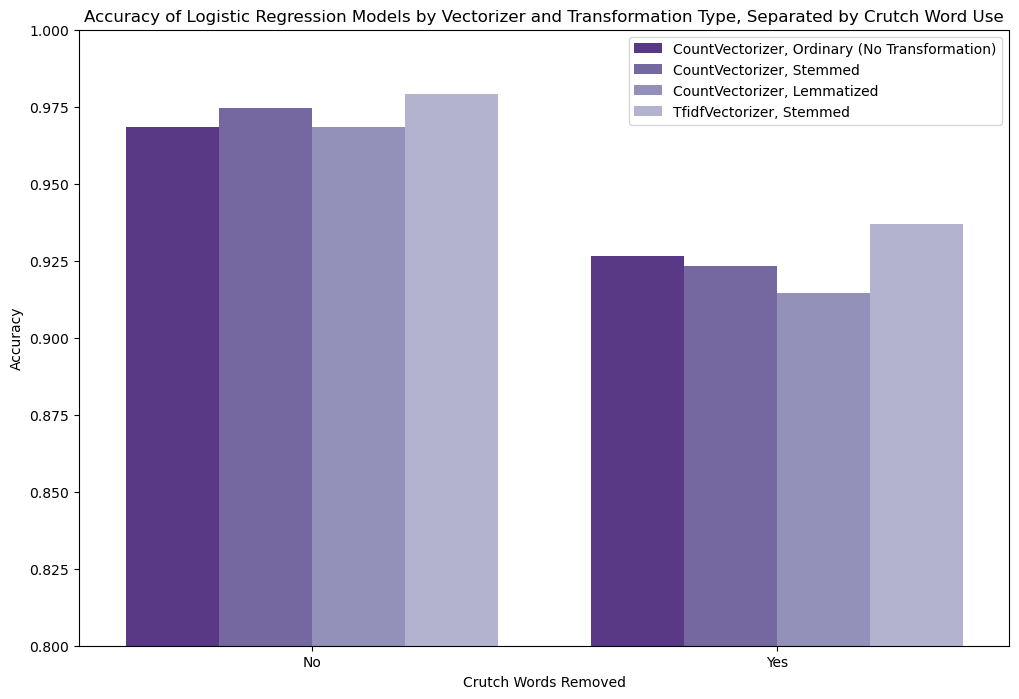

In [10]:
plt.figure(figsize = (12,8))

plt.ylim(ymin=.8, ymax=1)

sns.barplot(x=log_crutch,
            y=log_accuracy,
            hue=log_vec_transform,
            palette=log_palette,
            );

plt.title("Accuracy of Logistic Regression Models by Vectorizer and Transformation Type, Separated by Crutch Word Use")
plt.xlabel("Crutch Words Removed")
plt.ylabel("Accuracy")

plt.savefig('../images/log_accuracy_barplot.png')
plt.show()

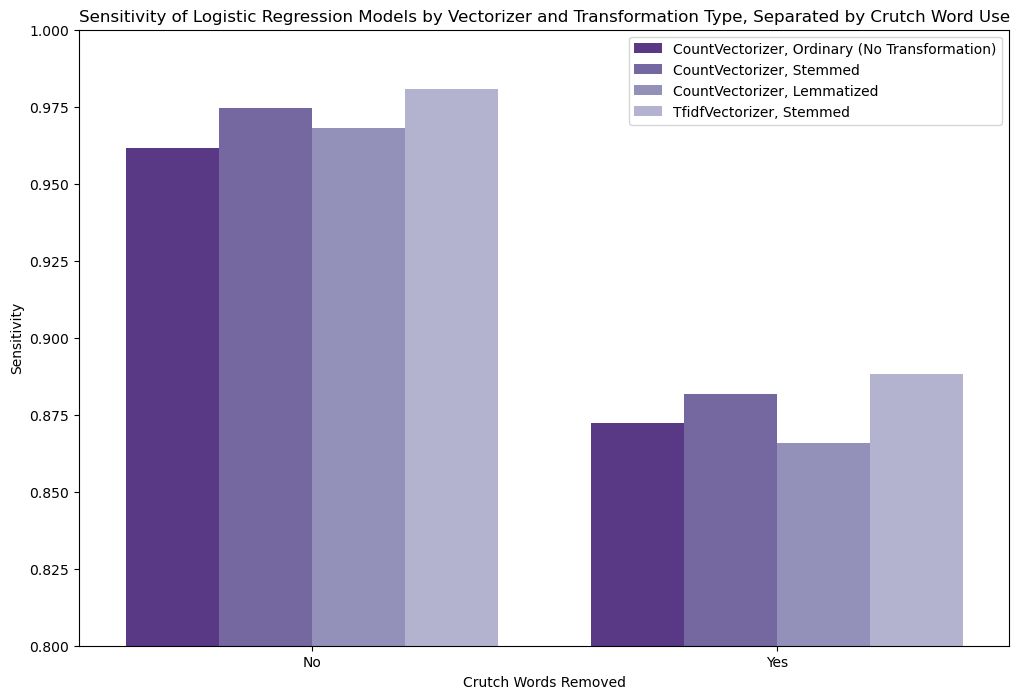

In [11]:
plt.figure(figsize = (12,8))

plt.ylim(ymin=.8, ymax=1)

sns.barplot(x=log_crutch,
            y=log_sensitivity,
            hue=log_vec_transform,
            palette=log_palette,
            );

plt.title("Sensitivity of Logistic Regression Models by Vectorizer and Transformation Type, Separated by Crutch Word Use")
plt.xlabel("Crutch Words Removed")
plt.ylabel("Sensitivity")

plt.savefig('../images/log_sensitivity_barplot.png')
plt.show()

Two items of note from these visualizations:
1) The models using the **TfidfVectorizer** were the top performers accross the board, outperforming the other models on both accuracy and sensitivity. This was true whether or not **Crutch Words** were removed
2) Removing the **crutch words** is a significant handicap to model performance. There is a large performance gap between the models that had access to the **crutch words** and those that did not. Furthermore, by comparing the two plots to each other, we can see that access to **crutch words** has an even greater impact on sensitivity than it does on accuracy

#### Comparing 'Crutch Words Allowed' Models ####

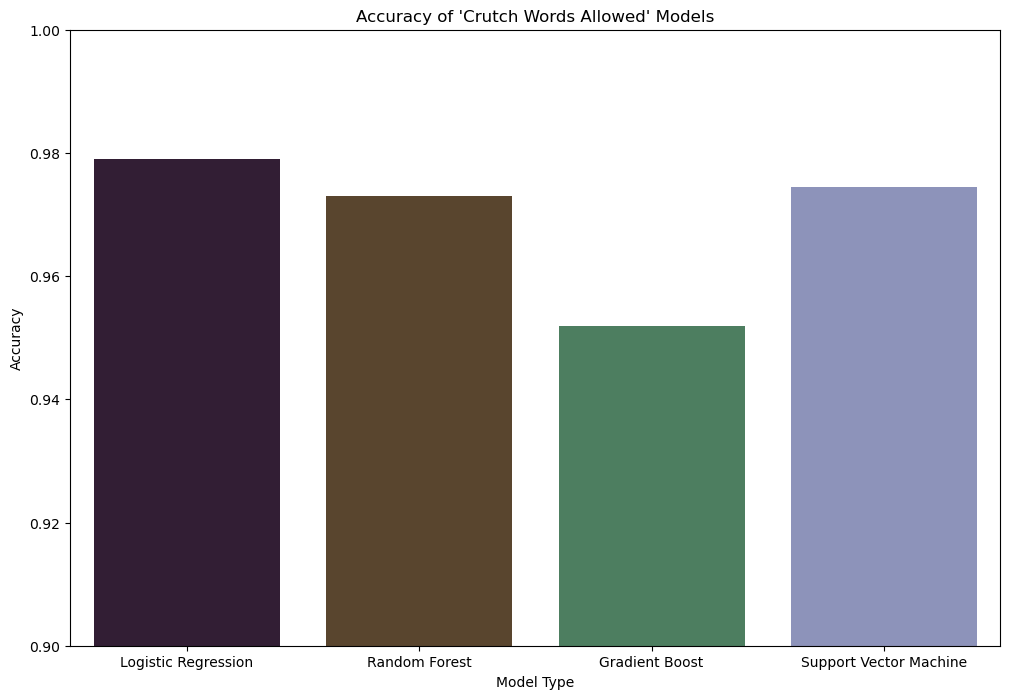

In [12]:
plt.figure(figsize = (12,8))

plt.ylim(ymin=.9, ymax=1)

sns.barplot(x=cno_model_type,
            y=cno_accuracy,
            palette=all_palette
            );

plt.title("Accuracy of 'Crutch Words Allowed' Models")
plt.xlabel("Model Type")
plt.ylabel("Accuracy")

plt.savefig('../images/cno_accuracy_barplot.png')
plt.show()

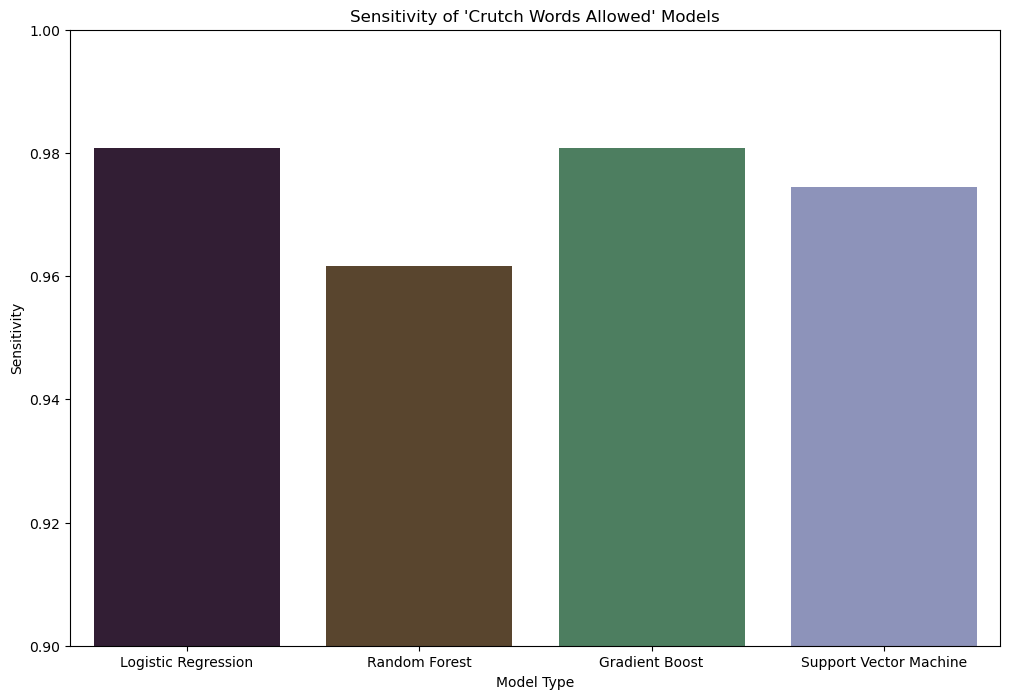

In [13]:
plt.figure(figsize = (12,8))

plt.ylim(ymin=.9, ymax=1)

sns.barplot(x=cno_model_type,
            y=cno_sensitivity,
            palette=all_palette,
            );

plt.title("Sensitivity of 'Crutch Words Allowed' Models")
plt.xlabel("Model Type")
plt.ylabel("Sensitivity")

plt.savefig('../images/cno_sensitivity_barplot.png')
plt.show()

Some takeaways from these visualizations:
1) Simple **Logistic Regression** performed quite well on both metrics, doing the best on accuracy, and coming in a close second place on Sensitivity
2) Although it was the weakest of the four models on the accuracy metric, **Gradient Boost** looks like the prime candidate for our production model, due to it's superior score on the sensitivity metric

#### Comparing 'Crutch Words Removed' Models ####

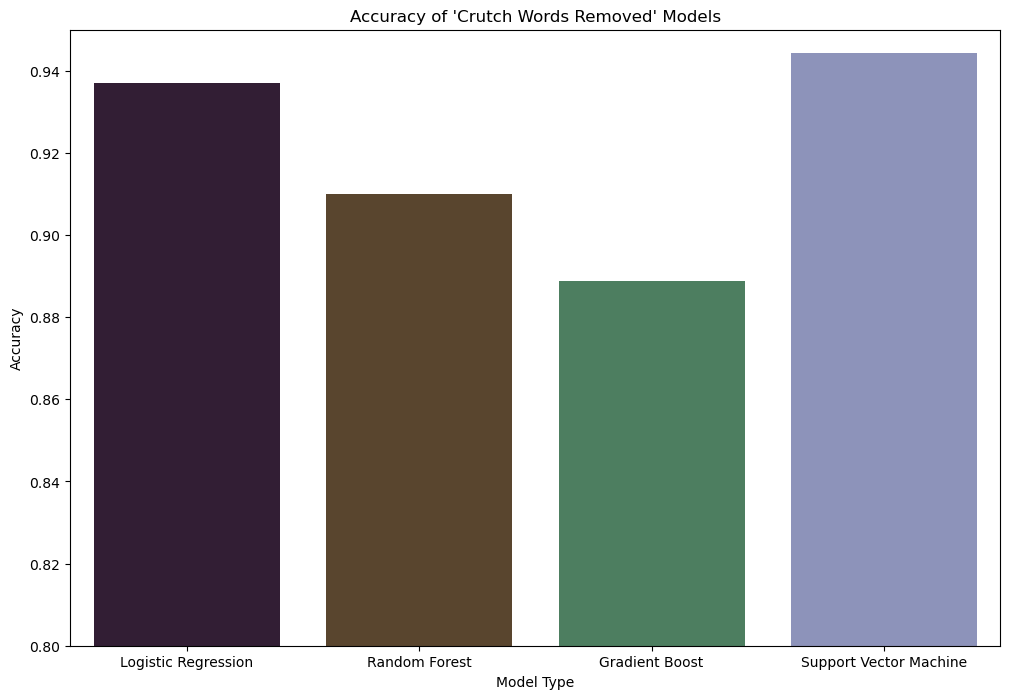

In [14]:
plt.figure(figsize = (12,8))

plt.ylim(ymin=.8, ymax=.95)

sns.barplot(x=cyes_model_type,
            y=cyes_accuracy,
            palette=all_palette,
            );

plt.title("Accuracy of 'Crutch Words Removed' Models")
plt.xlabel("Model Type")
plt.ylabel("Accuracy")

plt.savefig('../images/cyes_accuracy_barplot.png')
plt.show()

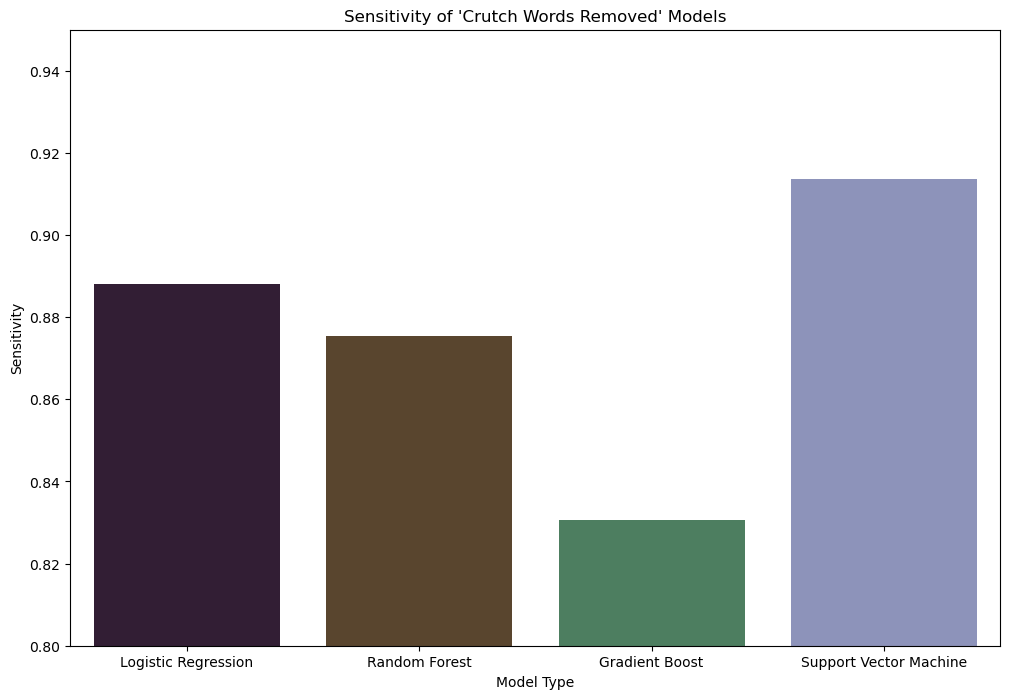

In [15]:
plt.figure(figsize = (12,8))

plt.ylim(ymin=.8, ymax=.95)

sns.barplot(x=cyes_model_type,
            y=cyes_sensitivity,
            palette=all_palette,
            );

plt.title("Sensitivity of 'Crutch Words Removed' Models")
plt.xlabel("Model Type")
plt.ylabel("Sensitivity")

plt.savefig('../images/cyes_sensitivity_barplot.png')
plt.show()

Some Takeaways:
1) **Support Vector Machine** is the clear winner here, besting the other model types in both accuracy and sensitivity. 
2) **Gradient Boost** takes the biggest hit from not having access to the **crutch words**. The strong sensitivity of the **Gradient Boost** model on the full dataset is completely inverted by the removal of **crutch words**, going from best to worst.

## Final Models ##

#### Defining X and y Variables ####

In [16]:
X = dogs_v_kids['title_post_stemmed']
y = dogs_v_kids['subreddit']

### Best Model on Crutch Words Removed Data - Support Vector Machine ###

The top performing model by far on the data with **crutch words** removed was **Support Vector Machine**. Although I have not selected it as my production model, it deserves special mention, as it still managed to perform strongly, despite not having access to some of the best available data

#### Model Instantiation and Fitting ####

In [17]:
svm_pipe = Pipeline([
    ('tvec', TfidfVectorizer(
        max_features = 4500,
        min_df = 4,
        max_df = 0.3,
        ngram_range = (1, 2),
        stop_words = crutch_words_stemmed
    )),
    ('svm', SVC(
        kernel = 'rbf',
        C = 1.9658620689655173,
        random_state = 1234
    ))
])

In [18]:
svm_pipe.fit(X, y)

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.3, max_features=4500, min_df=4,
                                 ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             'you', 're', 'you', 've', 'you',
                                             'll', 'you', 'd', 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'hi', 'himself', 'she',
                                             'she', 's', 'her', 'her', ...])),
                ('svm', SVC(C=1.9658620689655173, random_state=1234))])

#### Saving the Model ####

In [19]:
with open('../production_model/svm.pickle', 'wb') as f:
    pickle.dump(svm_pipe, f, protocol=pickle.HIGHEST_PROTOCOL)
# Code adapted from solution on https://stackoverflow.com/questions/11218477/how-can-i-use-pickle-to-save-a-dict-or-any-other-python-object

### Production Model - Gradient Boost ###

For my production model I've chosen the **Gradient Boost** model with **crutch words** allowed.

The client has made clear that they would rather incorrectly target some advertising towards childless adults then to miss out on reaching potential customers. I've therefore selected the model that best optimizes for **sensitivity**, which is **Gradient Boost**.

*Note: Handicapping my models using the **crutch words** list produced some interesting results that I will delve into further in my analysis below. For real world deployment, however, there is simply no business justification for denying the model access to some of the best data available to it. As such, none of the **crutch words removed** models were considered for production.*

#### Model Instantiation and Fitting ####

In [20]:
gb_pipe = Pipeline([
    ('tvec', TfidfVectorizer(
        max_features = 2000,
        min_df = 1,
        max_df = 0.3,
        ngram_range = (1, 2),
        stop_words = eng_stopwords_stemmed
    )),
    ('gb', GradientBoostingClassifier(
        n_estimators = 400,
        max_depth = 3,
        learning_rate = 0.1,
        random_state = 1234
    ))
])

In [21]:
gb_pipe.fit(X, y)

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.3, max_features=2000,
                                 ngram_range=(1, 2),
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'our', 'ourselv', 'you',
                                             'you', 're', 'you', 've', 'you',
                                             'll', 'you', 'd', 'your', 'your',
                                             'yourself', 'yourselv', 'he',
                                             'him', 'hi', 'himself', 'she',
                                             'she', 's', 'her', 'her', ...])),
                ('gb',
                 GradientBoostingClassifier(n_estimators=400,
                                            random_state=1234))])

#### Saving the Model ####

In [22]:
with open('../production_model/gb.pickle', 'wb') as f:
    pickle.dump(gb_pipe, f, protocol=pickle.HIGHEST_PROTOCOL)
# Code adapted from solution on https://stackoverflow.com/questions/11218477/how-can-i-use-pickle-to-save-a-dict-or-any-other-python-object

## Further Analysis and Visualizations from Final Model Output - Best Words

In [23]:
gb_words = pd.DataFrame({'feature_names': gb_pipe.steps[0][1].get_feature_names_out(),
              'feature_importance': gb_pipe.steps[1][1].feature_importances_})
gb_words.sort_values(by = 'feature_importance', ascending = False, inplace=True)
gb_best_words = gb_words.head(10)
gb_best_words.head()
# Code adapted from lesson 603, as well as https://stackoverflow.com/questions/38787612/how-to-extract-feature-importances-from-an-sklearn-pipeline

,feature_names,feature_importance
963,kid,0.201324
457,daughter,0.123884
1632,son,0.102949
1386,puppi,0.065577
186,babi,0.057924


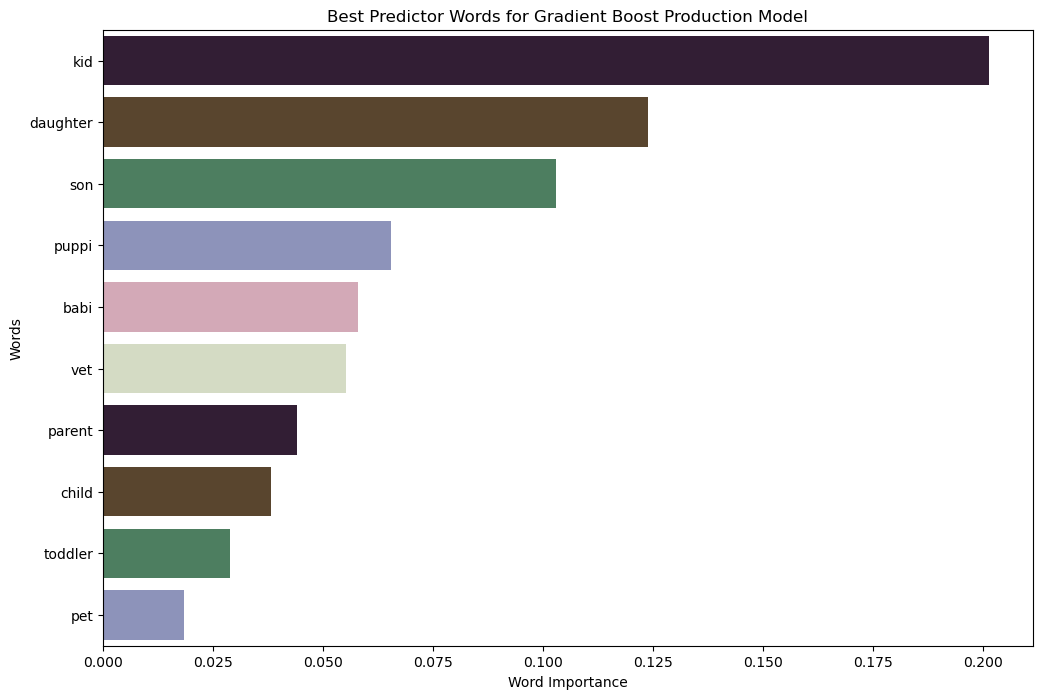

In [24]:
plt.figure(figsize = (12,8))

sns.barplot(x = gb_best_words['feature_importance'],
            y = gb_best_words['feature_names'],
            palette = all_palette);

plt.title("Best Predictor Words for Gradient Boost Production Model")
plt.xlabel("Word Importance")
plt.ylabel("Words")

plt.savefig('../images/gb_best_predictors.png')
plt.show()

It's not surprising to see that many of the best predictor words from our production model were part of the **crutch words** list. In fact, the first 6 words on this list were also part of the **crutch words** list

I would have loved to get the best predictor words out of my model that did not have access to **crutch words**, but because that model is a **Support Vector Machine**, that unfortunately won't be possible

## Conclusions ##

Using advanced machine learning techniques, I was able to build a model capable of differentiating between social media posts from parents talking about their children, and pet lovers talking about their dogs. This model should greatly aid **ABC Toy Co.** in targeting their online advertising towards the former group, eliminating wasteful spending while also ensuring that their ads are reaching their target demographic.

Although some models showed better performance on other metrics, I selected **Gradient Boost** as the best candidate for a production model. **Gradient Boost** displayed the best performance on the key **sensitivity** metric, correctly identifying 98.1% of the posts from the **r/parenting** subreddit in the test data.

While it would not make business sense to implement a model while denying it access to the best data, the **Support Vector Machine** model's performance on the data with **crutch words** removed was still notable. Even without access to some of the best differentiator words in the corpus of data, it was still able to correctly identify 91.4% of the posts from **r/parenting** in the test data, the only model to achieve a sensitivity score over 90% on this data.

## Recommendations ##

The high performing **Gradient Boost** model could be put into production in it's current form, and it would provide a significant boost to the effectiveness of ABC's ad targeting. That said, there are several ways in which the model could be further refined to improve performance even more:
- **More Data**: Model performance improves the more data it has to train on. This model was trained using a little more than 3,000 **Reddit** posts covering a time period of 14 days from 2/17/2023 to 3/2/2023. **Reddit** is a treasure trove of this kind of data, and those numbers could easily be expanded to hundreds of thousands or even millions of posts over several years. Comments on posts could be added to the mix as well
- **Ensembling**: Though **Gradient Boost** was the highest performing model on the **sensitivity** metric, many of the other models performed nearly as well. These models could be combined together to achieve even greater performance